<a href="https://colab.research.google.com/github/noweahc/energy/blob/main/%EB%AA%A8%EB%8D%B8%EB%A7%81%EA%B9%8C%EC%A7%80Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 불러오기 및 라이브러리 호출

In [5]:
!pip install sktime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.7/118.7 kB 15.1 MB/s eta 0:00:00


In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 16 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 3s (3,648 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120831 files and dire

In [1]:
import matplotlib.pyplot as plt # 맷플롯립 import 하기
plt.rcParams['font.family'] = 'NanumBarunGothic' # 나눔바른고딕 적용하기

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import os
from tqdm import tqdm
import sktime

from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from xgboost import XGBRegressor

In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
train = pd.read_csv('/content/drive/MyDrive/23energy/23data/train.csv',encoding = 'utf-8')
test = pd.read_csv('/content/drive/MyDrive/23energy/23data/test.csv',encoding = 'utf-8')
building = pd.read_csv('/content/drive/MyDrive/23energy/23data/building_info.csv',encoding = 'utf-8')

# train data 결측치 대체 및 데이터 전처리

In [9]:
train = train.rename(columns={
    '건물번호': 'num',
    '일시': 'date_time',
    '기온(C)': 'gion',
    '강수량(mm)': 'rain',
    '풍속(m/s)': 'wind',
    '습도(%)': 'hum',
    '일조(hr)': 'iljo',
    '일사(MJ/m2)': 'ilsa',
    '전력소비량(kWh)': 'power'
})
train.drop('num_date_time', axis = 1, inplace=True)

In [10]:
train.isnull().sum()

num               0
date_time         0
gion              0
rain         160069
wind             19
hum               9
iljo          75182
ilsa          87913
power             0
dtype: int64

In [11]:
test.isnull().sum()

num_date_time    0
건물번호             0
일시               0
기온(C)            0
강수량(mm)          0
풍속(m/s)          0
습도(%)            0
dtype: int64

In [12]:
train[(train['date_time'] == '2022-08-06 17:00:00') & (train['num'] == 51)]['hum']

Series([], Name: hum, dtype: float64)

In [13]:
#90번 건물 54로 대체
train.loc[(train['date_time'] == '2022-08-06 17:00:00') & (train['num'] == 90), 'hum'] = 54

In [14]:
#15번 건물 54로 대체
train.loc[(train['date_time'] == '2022-08-06 17:00:00') & (train['num'] == 15), 'hum'] = 54

In [15]:
#선형 보간으로 나머지 결측치 채우기
train['hum'] = train['hum'].interpolate()

In [16]:
train[(train['date_time'] == '2022-08-06 17:00:00') & (train['num'] == 51)]['wind']

Series([], Name: wind, dtype: float64)

In [17]:
#90번 건물 2.7로 대체
train.loc[(train['date_time'] == '2022-08-06 17:00:00') & (train['num'] == 90), 'wind'] = 2.7

In [18]:
#15번 건물 2.7로 대체
train.loc[(train['date_time'] == '2022-08-06 17:00:00') & (train['num'] == 15), 'wind'] = 2.7

In [19]:
#선형 보간으로 나머지 결측치 채우기
train['wind'] = train['wind'].interpolate()

In [20]:
train.isnull().sum()

num               0
date_time         0
gion              0
rain         160069
wind              0
hum               0
iljo          75182
ilsa          87913
power             0
dtype: int64

In [21]:
test = test.rename(columns={
    '건물번호': 'num',
    '일시': 'date_time',
    '기온(C)': 'gion',
    '강수량(mm)': 'rain',
    '풍속(m/s)': 'wind',
    '습도(%)': 'hum',
    '일조(hr)': 'iljo',
    '일사(MJ/m2)': 'ilsa',
    '전력소비량(kWh)': 'power'
})
test.drop('num_date_time', axis = 1, inplace=True)

In [22]:
building = building.rename(columns={
    '건물번호': 'num',
    '건물유형': 'type',
    '연면적(m2)': 'total_area',
    '냉방면적(m2)': 'cooling_area',
    '태양광용량(kW)': 'solar',
    'ESS저장용량(kWh)': 'ess',
    'PCS용량(kW)': 'pcs'
})

In [23]:
train = pd.merge(train, building, on='num', how='left')
test = pd.merge(test, building, on='num', how='left')

# 파생변수 생성

In [24]:
def make_time(train):
    """
    시간 관련 변수를 추가하기 위한 함수
    """
    train['date_time'] = pd.to_datetime(train.date_time)

    train['month'] = train.date_time.dt.month                    # 월(숫자)
    train['day'] = train.date_time.dt.day                        # 일(숫자)
    train['hour'] = train.date_time.dt.hour                      # 시(숫자)
    train['weekday'] = train.date_time.dt.weekday                # 요일(숫자)
    train['dayofyear'] = train.date_time.dt.dayofyear            # 연 기준 몇일째(숫자)
    train['monthday'] = train.date_time.dt.strftime('%m%d')      # 월일

    return train

In [25]:
train = make_time(train)
test = make_time(test)

In [26]:
dfs = {i: test[test['num'] == i][['gion','rain','wind', 'hum','month','day','hour']].reset_index(drop=True) for i in test['num'].unique()}


In [27]:
group = []

for i in test['num'].unique():
    if i in dfs:                  # 이미 그룹으로 묶여서 삭제된 건물인지 체크
        similar_buildings = [i]   # 현재 건물 번호 추가
        for j in test['num'].unique():
            if j > i and j in dfs and dfs[i].equals(dfs[j]):  # i 건물보다 큰 번호의 건물과 비교
                similar_buildings.append(j)
                del dfs[j]        # 동일한 건물은 추후 비교에서 제외하기 위해 삭제

        group.append(similar_buildings)

group[:5]

[[1,
  2,
  3,
  4,
  5,
  17,
  19,
  24,
  25,
  32,
  33,
  34,
  35,
  37,
  38,
  41,
  45,
  53,
  57,
  59,
  60,
  61,
  62,
  68,
  69,
  74,
  80,
  81,
  85,
  93,
  94],
 [6, 7, 12, 18, 36, 47, 58, 73, 77, 78, 79, 83, 84, 86, 92],
 [8, 11],
 [9],
 [10, 13, 54, 67, 96]]

In [28]:
# 각 그룹에 속한 건물 번호에 대한 딕셔너리
dict = {i+1: group[i] for i in range(len(group))}
print(dict)

{1: [1, 2, 3, 4, 5, 17, 19, 24, 25, 32, 33, 34, 35, 37, 38, 41, 45, 53, 57, 59, 60, 61, 62, 68, 69, 74, 80, 81, 85, 93, 94], 2: [6, 7, 12, 18, 36, 47, 58, 73, 77, 78, 79, 83, 84, 86, 92], 3: [8, 11], 4: [9], 5: [10, 13, 54, 67, 96], 6: [14, 64, 82, 88, 89], 7: [15, 51, 90], 8: [16], 9: [20], 10: [21], 11: [22, 43, 44], 12: [23, 66], 13: [26], 14: [27, 39, 56, 63, 70, 71], 15: [28, 98], 16: [29], 17: [30], 18: [31], 19: [40, 48, 49, 55, 65, 72, 91], 20: [42, 50], 21: [46], 22: [52, 97], 23: [75], 24: [76], 25: [87], 26: [95], 27: [99], 28: [100]}


In [29]:
def get_group(df):
    for key, values in dict.items():
        if df['num'] in values:
            return key
    return None  # 그룹에 속하지 않는 경우

train['group'] = train.apply(get_group, axis=1)
test['group'] = test.apply(get_group, axis=1)


In [30]:
#토요일, 일요일은 주말로 처리
#전국동시지방선거일, 현충일, 광복절도 주말로 처리

train.loc[train.weekday >= 5, 'holiday'] = 1
train.loc[(train.weekday < 5), 'holiday'] = 0

#train.loc[train.monthday == '0601', 'holiday'] = 1
#train.loc[train.monthday == '0606', 'holiday'] = 1
#train.loc[train.monthday == '0815', 'holiday'] = 1
train.loc[train['monthday'].isin(['0601', '0606', '0815']), 'holiday'] = 1

test.loc[test.weekday >= 5, 'holiday'] = 1
test.loc[test.weekday < 5, 'holiday'] = 0

In [31]:
#09-18시 활동시간 변수 awake 설정 (1이면 활동시간대)
train.loc[train.hour > 18 , 'awake'] = 0
train.loc[train.hour < 9, 'awake'] = 0
train.loc[(9 <= train.hour) & (train.hour <= 18), 'awake'] = 1

In [32]:
test.loc[test.hour > 18 , 'awake'] = 0
test.loc[test.hour < 9, 'awake'] = 0
test.loc[(9 <= test.hour) & (test.hour <= 18), 'awake'] = 1

In [33]:
#######################################
## 건물별, 요일별, 시간별 발전량 평균 넣어주기
#######################################
power_mean = pd.pivot_table(train, values = 'power', index = ['num', 'hour', 'day'], aggfunc = np.mean).reset_index()
tqdm.pandas()
train['day_hour_mean'] = train.progress_apply(lambda x : power_mean.loc[(power_mean.num == x['num']) & (power_mean.hour == x['hour']) & (power_mean.day == x['day']) ,'power'].values[0], axis = 1)

#######################################
## 건물별 시간별 발전량 평균 넣어주기
#######################################
power_hour_mean = pd.pivot_table(train, values = 'power', index = ['num', 'hour'], aggfunc = np.mean).reset_index()
tqdm.pandas()
train['hour_mean'] = train.progress_apply(lambda x : power_hour_mean.loc[(power_hour_mean.num == x['num']) & (power_hour_mean.hour == x['hour']) ,'power'].values[0], axis = 1)

#######################################
## 건물별 시간별 발전량 표준편차 넣어주기
#######################################
power_hour_std = pd.pivot_table(train, values = 'power', index = ['num', 'hour'], aggfunc = np.std).reset_index()
tqdm.pandas()
train['hour_std'] = train.progress_apply(lambda x : power_hour_std.loc[(power_hour_std.num == x['num']) & (power_hour_std.hour == x['hour']) ,'power'].values[0], axis = 1)

#######################################
## 건물별 awake 시간 여부에 따라 발전량 평균 넣어주기
#######################################
power_awake_mean = pd.pivot_table(train, values = 'power', index = ['num', 'awake'], aggfunc = np.mean).reset_index()
tqdm.pandas()
train['awake_mean'] = train.progress_apply(lambda x : power_awake_mean.loc[(power_awake_mean.num == x['num']) & (power_awake_mean.awake == x['awake']) ,'power'].values[0], axis = 1)

#######################################
## 건물별 awake 시간 여부에 따라 발전량 표준편차 넣어주기
#######################################
power_awake_std = pd.pivot_table(train, values = 'power', index = ['num', 'awake'], aggfunc = np.std).reset_index()
tqdm.pandas()
train['awake_std'] = train.progress_apply(lambda x : power_awake_std.loc[(power_awake_std.num == x['num']) & (power_awake_std.awake == x['awake']) ,'power'].values[0], axis = 1)

#######################################
## 건물별 holiday 여부에 따라 발전량 평균 넣어주기
#######################################
power_holiday_mean = pd.pivot_table(train, values = 'power', index = ['num', 'holiday'], aggfunc = np.mean).reset_index()
tqdm.pandas()
train['holiday_mean'] = train.progress_apply(lambda x : power_holiday_mean.loc[(power_holiday_mean.num == x['num']) & (power_holiday_mean.holiday == x['holiday']) ,'power'].values[0], axis = 1)

#######################################
## 건물별 holiday 여부에 따라 발전량 표준편차 넣어주기
#######################################
power_holiday_std = pd.pivot_table(train, values = 'power', index = ['num', 'holiday'], aggfunc = np.std).reset_index()
tqdm.pandas()
train['holiday_std'] = train.progress_apply(lambda x : power_holiday_std.loc[(power_holiday_std.num == x['num']) & (power_holiday_std.holiday == x['holiday']) ,'power'].values[0], axis = 1)

#######################################
## 유사 위치 그룹별 시간별 발전량 평균 넣어주기
#######################################
power_group_mean = pd.pivot_table(train, values = 'power', index = ['group', 'hour'], aggfunc = np.mean).reset_index()
tqdm.pandas()
train['group_mean'] = train.progress_apply(lambda x : power_group_mean.loc[(power_group_mean.group == x['group']) & (power_group_mean.hour == x['hour']) ,'power'].values[0], axis = 1)

#######################################
## 유사 위치 그룹별 시간별 발전량 표준편차 넣어주기
#######################################
power_group_std = pd.pivot_table(train, values = 'power', index = ['group', 'hour'], aggfunc = np.std).reset_index()
tqdm.pandas()
train['group_std'] = train.progress_apply(lambda x : power_group_std.loc[(power_group_std.group == x['group']) & (power_group_std.hour == x['hour']) ,'power'].values[0], axis = 1)



100%|██████████| 204000/204000 [01:29<00:00, 2268.96it/s]


In [34]:
#test
#######################################
## 건물별, 요일별, 시간별 발전량 평균 넣어주기
#######################################
tqdm.pandas()
test['day_hour_mean'] = test.progress_apply(lambda x : power_mean.loc[(power_mean.num == x['num']) & (power_mean.hour == x['hour']) & (power_mean.day == x['day']) ,'power'].values[0], axis = 1)

#######################################
## 건물별 시간별 발전량 평균 넣어주기
#######################################
tqdm.pandas()
test['hour_mean'] = test.progress_apply(lambda x : power_hour_mean.loc[(power_hour_mean.num == x['num']) & (power_hour_mean.hour == x['hour']) ,'power'].values[0], axis = 1)

#######################################
## 건물별 시간별 발전량 표준편차 넣어주기
#######################################
tqdm.pandas()
test['hour_std'] = test.progress_apply(lambda x : power_hour_std.loc[(power_hour_std.num == x['num']) & (power_hour_std.hour == x['hour']) ,'power'].values[0], axis = 1)

#######################################
## 건물별 awake 시간 여부에 따라 발전량 평균 넣어주기
#######################################
tqdm.pandas()
test['awake_mean'] = test.progress_apply(lambda x : power_awake_mean.loc[(power_awake_mean.num == x['num']) & (power_awake_mean.awake == x['awake']) ,'power'].values[0], axis = 1)

#######################################
## 건물별 awake 시간 여부에 따라 발전량 표준편차 넣어주기
#######################################
tqdm.pandas()
test['awake_std'] = test.progress_apply(lambda x : power_awake_std.loc[(power_awake_std.num == x['num']) & (power_awake_std.awake == x['awake']) ,'power'].values[0], axis = 1)

#######################################
## 건물별 holiday 여부에 따라 발전량 평균 넣어주기
#######################################
tqdm.pandas()
test['holiday_mean'] = test.progress_apply(lambda x : power_holiday_mean.loc[(power_holiday_mean.num == x['num']) & (power_holiday_mean.holiday == x['holiday']) ,'power'].values[0], axis = 1)

#######################################
## 건물별 holiday 여부에 따라 발전량 표준편차 넣어주기
#######################################
tqdm.pandas()
test['holiday_std'] = test.progress_apply(lambda x : power_holiday_std.loc[(power_holiday_std.num == x['num']) & (power_holiday_std.holiday == x['holiday']) ,'power'].values[0], axis = 1)

#######################################
## 유사 위치 그룹별 시간별 발전량 평균 넣어주기
#######################################
tqdm.pandas()
test['group_mean'] = test.progress_apply(lambda x : power_group_mean.loc[(power_group_mean.group == x['group']) & (power_group_mean.hour == x['hour']) ,'power'].values[0], axis = 1)

#######################################
## 유사 위치 그룹별 시간별 발전량 표준편차 넣어주기
#######################################
tqdm.pandas()
test['group_std'] = test.progress_apply(lambda x : power_group_std.loc[(power_group_std.group == x['group']) & (power_group_std.hour == x['hour']) ,'power'].values[0], axis = 1)



100%|██████████| 16800/16800 [00:08<00:00, 2017.70it/s]


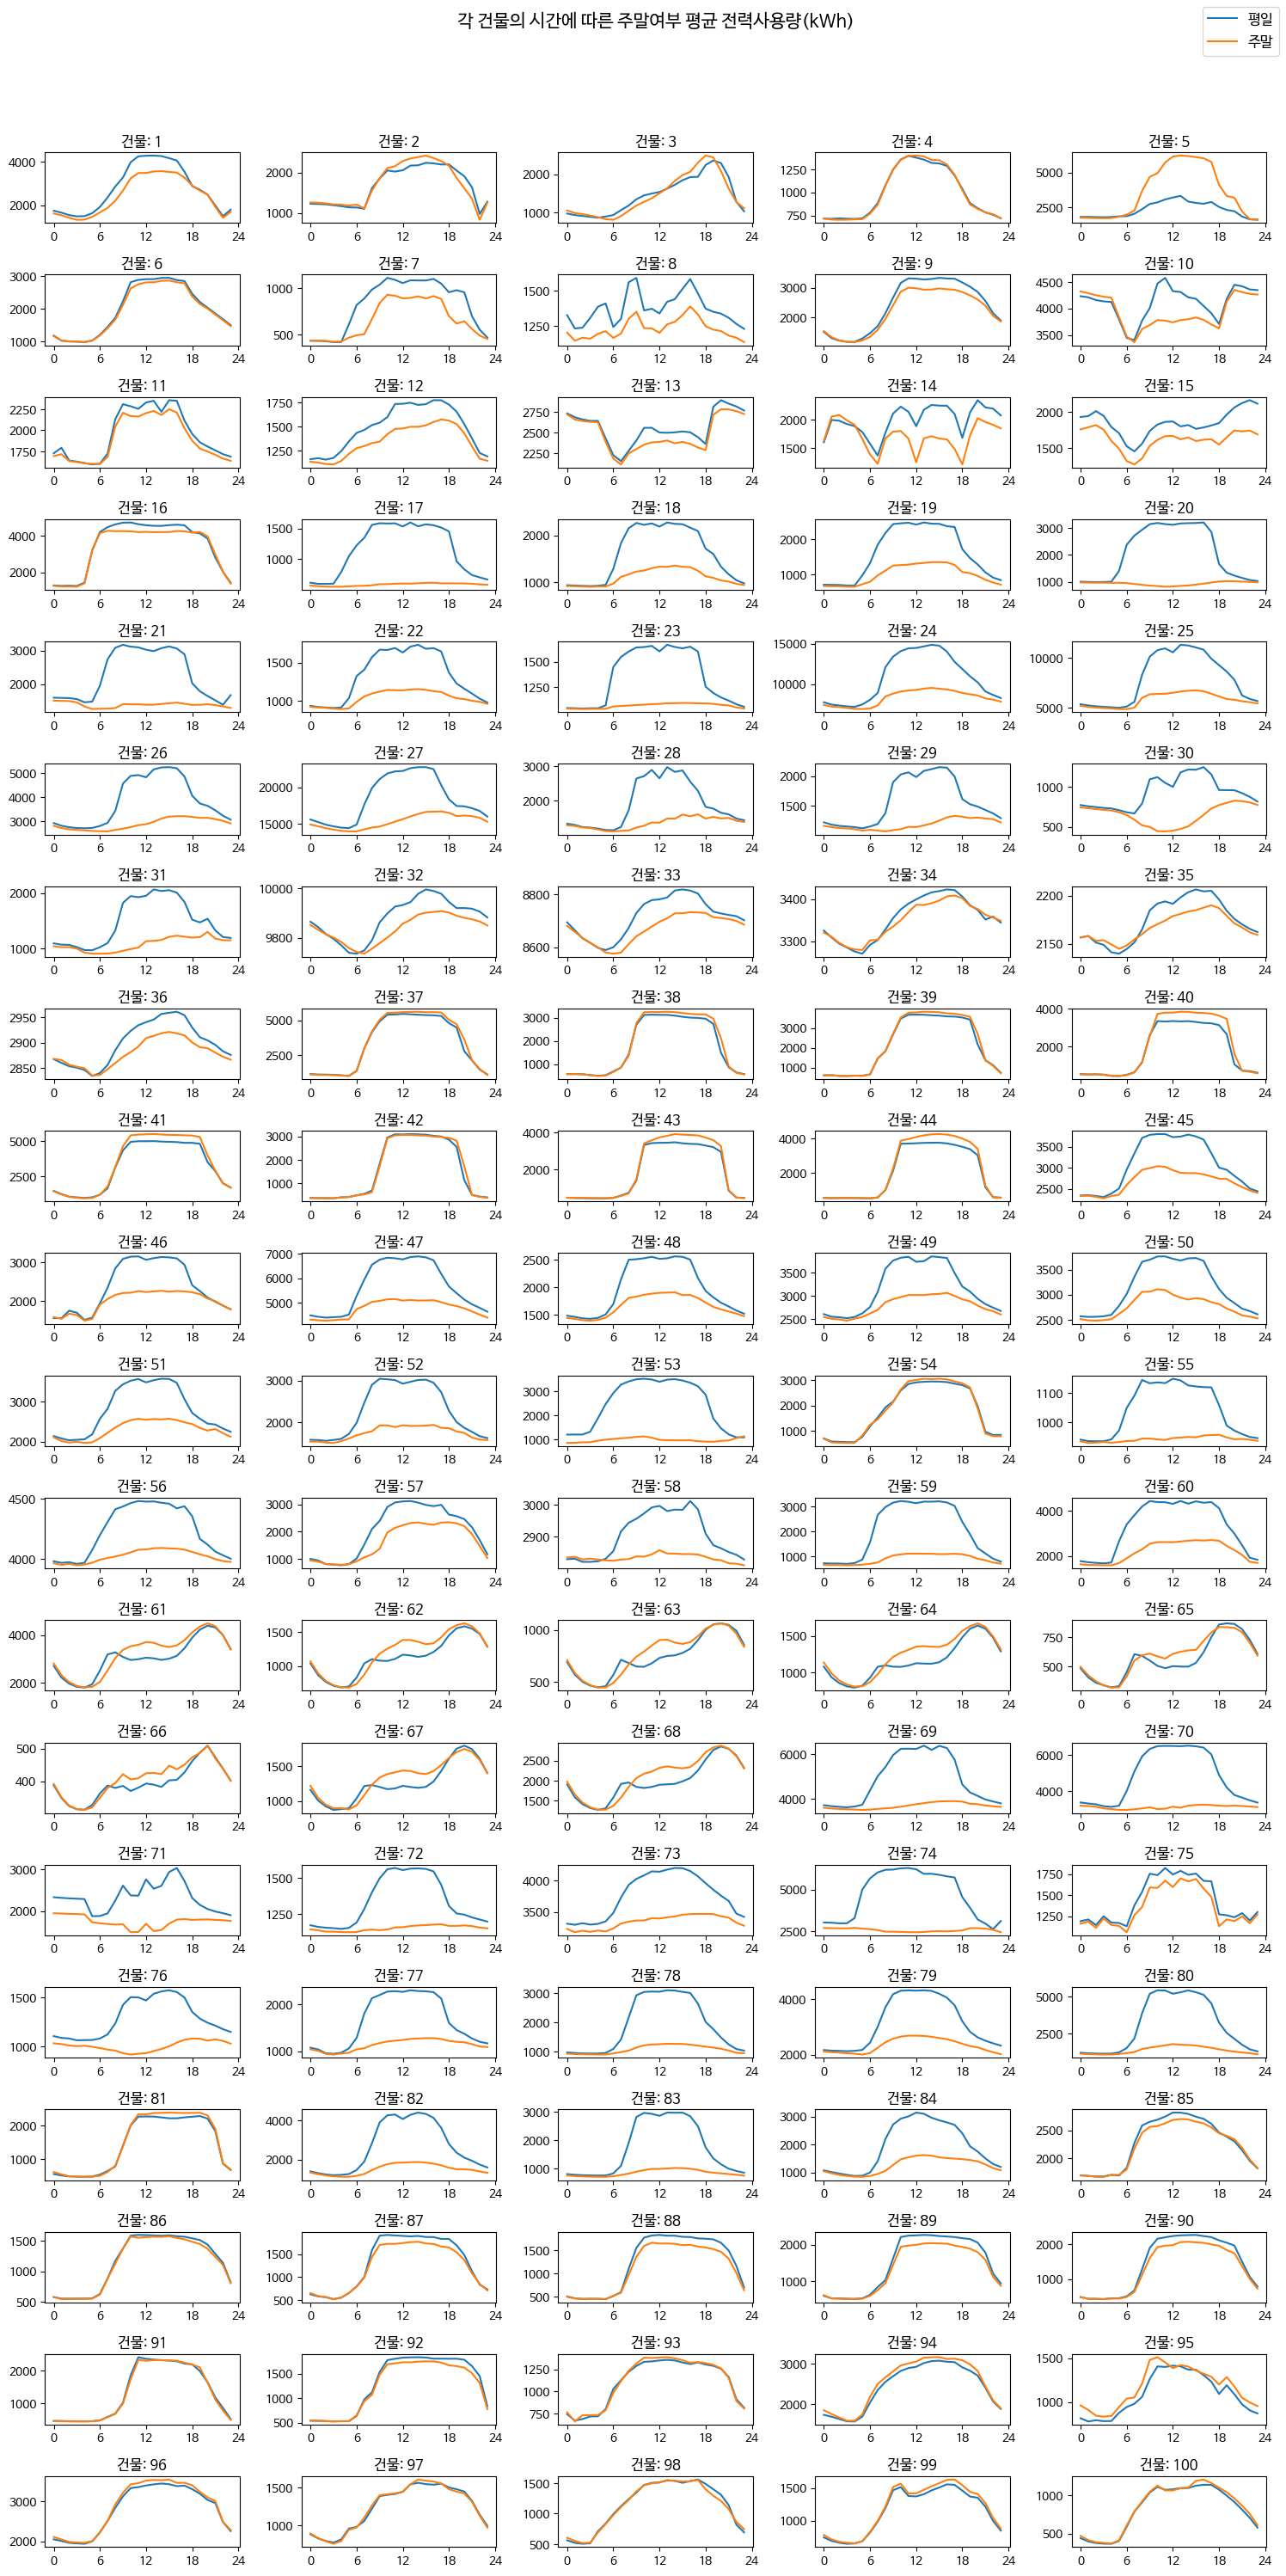

In [35]:
fig = plt.figure(figsize = (15 ,30))
plt.title("각 건물의 시간에 따른 주말여부 평균 전력사용량(kWh)", fontsize=15, y=1.05)
plt.axis('off')

for num in range(1,101):
    df = train[train.num==num]
    ax = fig.add_subplot(20,5,num)
    ax.plot(df['hour'].unique(), df[df.holiday==0].groupby('hour')['power'].mean(), label='평일')
    ax.plot(df['hour'].unique(), df[df.holiday==1].groupby('hour')['power'].mean(), label='주말')
    ax.set_title(f'건물: {num}')
    ax.set_xticks([0,6,12,18,24])
lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, loc = 1, prop={'size':12})
plt.tight_layout()
plt.show()

In [36]:
# 문자열을 실수형으로 변환하고 "-"을 0으로 대체합니다.
train["solar"] = train["solar"].apply(lambda x: float(x) if x != "-" else 0)
train["ess"] = train["ess"].apply(lambda x: float(x) if x != "-" else 0)
train["pcs"] = train["pcs"].apply(lambda x: float(x) if x != "-" else 0)

# 문자열을 실수형으로 변환하고 "-"을 0으로 대체합니다.
test["solar"] = test["solar"].apply(lambda x: float(x) if x != "-" else 0)
test["ess"] = test["ess"].apply(lambda x: float(x) if x != "-" else 0)
test["pcs"] = test["pcs"].apply(lambda x: float(x) if x != "-" else 0)

In [37]:
#건물유형 숫자로 처리하는 라벨인코딩

label_mapping = {
    '건물기타': 0,
    '공공': 1,
    '대학교': 2,
    '데이터센터': 3,
    '백화점및아울렛': 4,
    '병원': 5,
    '상용': 6,
    '아파트': 7,
    '연구소': 8,
    '지식산업센터': 9,
    '할인마트': 10,
    '호텔및리조트': 11
}

train['type'] = train['type'].replace(label_mapping)
test['type'] = test['type'].replace(label_mapping)

In [38]:
#파생변수 : 체감온도
train['sensory_temp'] = 13.12 + 0.6215 * train['gion'] - 11.37 * (train['wind'] ** 0.16) + 0.3965 * (train['wind'] ** 0.16) * train['gion']
test['sensory_temp'] = 13.12 + 0.6215 * test['gion'] - 11.37 * (test['wind'] ** 0.16) + 0.3965 * (test['wind'] ** 0.16) * test['gion']

In [39]:
#https://dacon.io/competitions/official/235680/codeshare/2366?page=1&dtype=recent
#아이디어 참고
#시간의 순환적 성격 반영하기

train['sin_time'] = np.sin(2*np.pi*train.hour/24)
train['cos_time'] = np.cos(2*np.pi*train.hour/24)

test['sin_time'] = np.sin(2*np.pi*test.hour/24)
test['cos_time'] = np.cos(2*np.pi*test.hour/24)

In [40]:
#https://dacon.io/competitions/official/235736/codeshare/2743?page=1&dtype=recent
#아이디어 참고
#기온과 습도를 고려한 불쾌지수(THI)
#CDH(Cooling Degree Hour) : 기온이 실제 냉방 가동에 이르기까지의 시간적 오차를 고려

train['THI'] = 9/5*train['gion'] - 0.55*(1-train['hum']/100)*(9/5*train['hum']-26)+32
test['THI'] = 9/5*test['gion'] - 0.55*(1-test['hum']/100)*(9/5*test['hum']-26)+32


def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11:
            ys.append(np.sum(xs[:(i+1)]-26))
        else:
            ys.append(np.sum(xs[(i-11):(i+1)]-26))
    return np.array(ys)


cdhs = np.array([])
for num in range(1,101,1):
    temp = train[train['num'] == num]
    cdh = CDH(temp['gion'].values)
    cdhs = np.concatenate([cdhs, cdh])
train['CDH'] = cdhs


cdhs = np.array([])
for num in range(1,101,1):
    temp = test[test['num'] == num]
    cdh = CDH(temp['gion'].values)
    cdhs = np.concatenate([cdhs, cdh])
test['CDH'] = cdhs

# 하이퍼파라미터 튜닝 및 건물 별 모델링

In [41]:
train.columns

Index(['num', 'date_time', 'gion', 'rain', 'wind', 'hum', 'iljo', 'ilsa',
       'power', 'type', 'total_area', 'cooling_area', 'solar', 'ess', 'pcs',
       'month', 'day', 'hour', 'weekday', 'dayofyear', 'monthday', 'group',
       'holiday', 'awake', 'day_hour_mean', 'hour_mean', 'hour_std',
       'awake_mean', 'awake_std', 'holiday_mean', 'holiday_std', 'group_mean',
       'group_std', 'sensory_temp', 'sin_time', 'cos_time', 'THI', 'CDH'],
      dtype='object')

In [42]:
#모델링에 사용할 컬럼만 남기기

train.drop(['rain','iljo','ilsa','solar','ess','pcs','hour','monthday'], axis = 1, inplace = True)
train.head()

,num,date_time,gion,wind,hum,power,type,total_area,cooling_area,month,...,awake_std,holiday_mean,holiday_std,group_mean,group_std,sensory_temp,sin_time,cos_time,THI,CDH
0,1,2022-06-01 00:00:00,18.6,0.9,42.0,1085.28,0,110634.0,39570.0,6,...,582.833488,2415.612593,978.582882,2358.555780,2358.329460,20.751584,0.000000,1.000000,49.6576,-7.4
1,1,2022-06-01 01:00:00,18.0,1.1,45.0,1047.36,0,110634.0,39570.0,6,...,582.833488,2415.612593,978.582882,2286.762592,2344.938054,20.008954,0.258819,0.965926,47.7625,-15.4
2,1,2022-06-01 02:00:00,17.7,1.5,45.0,974.88,0,110634.0,39570.0,6,...,582.833488,2415.612593,978.582882,2239.110455,2340.833175,19.476910,0.500000,0.866025,47.2225,-23.7
3,1,2022-06-01 03:00:00,16.7,1.4,48.0,953.76,0,110634.0,39570.0,6,...,582.833488,2415.612593,978.582882,2212.664459,2334.465875,18.487958,0.707107,0.707107,44.7856,-33.0
4,1,2022-06-01 04:00:00,18.4,2.8,43.0,986.40,0,110634.0,39570.0,6,...,582.833488,2415.612593,978.582882,2227.944478,2325.051520,19.751534,0.866025,0.500000,49.0061,-40.6


In [43]:
test.head()

,num,date_time,gion,rain,wind,hum,type,total_area,cooling_area,solar,...,awake_std,holiday_mean,holiday_std,group_mean,group_std,sensory_temp,sin_time,cos_time,THI,CDH
0,1,2022-08-25 00:00:00,23.5,0.0,2.2,72,0,110634.0,39570.0,0.0,...,582.833488,2763.53931,1154.438072,2358.555780,2358.329460,25.397063,0.000000,1.000000,58.3456,-2.5
1,1,2022-08-25 01:00:00,23.0,0.0,0.9,72,0,110634.0,39570.0,0.0,...,582.833488,2763.53931,1154.438072,2286.762592,2344.938054,25.201620,0.258819,0.965926,57.4456,-5.5
2,1,2022-08-25 02:00:00,22.7,0.0,1.5,75,0,110634.0,39570.0,0.0,...,582.833488,2763.53931,1154.438072,2239.110455,2340.833175,24.699788,0.500000,0.866025,57.8725,-8.8
3,1,2022-08-25 03:00:00,22.1,0.0,1.3,78,0,110634.0,39570.0,0.0,...,582.833488,2763.53931,1154.438072,2212.664459,2334.465875,24.136018,0.707107,0.707107,57.9376,-12.7
4,1,2022-08-25 04:00:00,21.8,0.0,1.0,77,0,110634.0,39570.0,0.0,...,582.833488,2763.53931,1154.438072,2227.944478,2325.051520,23.942400,0.866025,0.500000,56.9961,-16.9


In [44]:
# Define SMAPE loss function
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) * 100

In [45]:
from sklearn.metrics import make_scorer
smape = make_scorer(SMAPE, greater_is_better = False)

In [46]:
#### alpha를 argument로 받는 함수로 실제 objective function을 wrapping하여 alpha값을 쉽게 조정할 수 있도록 작성했습니다.
# custom objective function for forcing model not to underestimate

def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

In [ ]:
from sklearn.model_selection import PredefinedSplit, GridSearchCV
df = pd.DataFrame(columns = ['n_estimators', 'eta', 'min_child_weight','max_depth', 'colsample_bytree', 'subsample'])
preds = np.array([])

grid = {'n_estimators' : [100], 'eta' : [0.01], 'min_child_weight' : np.arange(1, 8, 1),
        'max_depth' : np.arange(3,9,1) , 'colsample_bytree' :np.arange(0.8, 1.0, 0.1),
        'subsample' :np.arange(0.8, 1.0, 0.1)} # fix the n_estimators & eta(learning rate)

for i in tqdm(np.arange(1, 101)):
    y = train.loc[train.num == i, 'power']
    x = train.loc[train.num == i, train.columns != 'power'].iloc[:, 2:]

    #y_train, y_test, x_train, x_test = temporal_train_test_split(y = y, X = x, test_size = 168)


    pds = PredefinedSplit(np.append(-np.ones(len(x)-168), np.zeros(168)))
    gcv = GridSearchCV(estimator = XGBRegressor(seed = 0, gpu_id = 1,
                                                tree_method = 'gpu_hist', predictor= 'gpu_predictor'),
                       param_grid = grid, scoring = smape, cv = pds, refit = True, verbose = True)


    gcv.fit(x, y)
    best = gcv.best_estimator_
    params = gcv.best_params_
    print(params)

    y_train, y_test, x_train, x_test = temporal_train_test_split(y = y, X = x, test_size = 168)
    pred = best.predict(x_test)
    building = 'building'+str(i)
    print(building + '|| SMAPE : {}'.format(SMAPE(y_test, pred)))
    preds = np.append(preds, pred)
    df = pd.concat([df, pd.DataFrame(params, index = [0])], axis = 0)


  0%|          | 0/100 [00:00<?, ?it/s]

Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:29:30] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:29:31] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:29:31] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:29:31] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:29:31] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:29:31] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:29:32] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:29:32] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:29:32] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:29:32] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:29:32] WARNING: ../src/learner.cc

  1%|          | 1/100 [00:34<57:02, 34.57s/it]

building1|| SMAPE : 22.160270802709498
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:30:04] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:30:04] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:30:04] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:30:05] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:30:05] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:30:05] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:30:05] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:30:05] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:30:05] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:30:05] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 

  2%|▏         | 2/100 [01:10<58:10, 35.61s/it]

[03:30:40] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building2|| SMAPE : 21.518090123021697
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:30:40] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:30:41] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:30:41] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:30:41] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:30:41] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:30:41] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:30:41] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:30:41] WARNING: ../src/learner.cc:347: Only 1 GPUs are vi

  3%|▎         | 3/100 [01:49<59:46, 36.97s/it]


Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:31:19] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:31:19] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:31:20] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:31:20] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:31:20] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:31:20] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:31:21] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:31:21] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:31:21] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:31:21] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:31:21] WARNING: ../src/learner.c

  4%|▍         | 4/100 [02:19<55:00, 34.38s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
building4|| SMAPE : 22.235069321634825
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:31:49] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:31:50] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:31:50] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:31:50] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:31:50] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:31:50] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:31:50] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:31:50] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:31:50] WARNING: ../src/learner.cc:347: Only 1 GPUs are vi

  5%|▌         | 5/100 [02:57<56:04, 35.42s/it]

building5|| SMAPE : 22.536207912190466
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:32:27] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:32:27] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:32:28] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:32:28] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:32:28] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:32:29] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:32:29] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:32:29] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:32:29] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:32:30] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 

  6%|▌         | 6/100 [03:30<54:14, 34.63s/it]

[03:33:00] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building6|| SMAPE : 23.083764203375505
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:33:00] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:33:00] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:33:00] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:33:00] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:33:00] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:33:00] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:33:01] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:33:01] WARNING: ../src/learner.cc:347: Only 1 GPUs are vi

  7%|▋         | 7/100 [04:05<53:48, 34.72s/it]

building7|| SMAPE : 19.82113815518064
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:33:35] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:33:35] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:33:36] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:33:36] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:33:37] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:33:37] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:33:37] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:33:38] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:33:38] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:33:38] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0

  8%|▊         | 8/100 [04:39<53:14, 34.73s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building8|| SMAPE : 22.259857339790017
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:34:09] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:34:10] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:34:10] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:34:10] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:34:10] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:34:10] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:34:10] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:34:10] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:34:11] WARNING: ../src/learner.cc:347: Only 1 GPUs are vi

  9%|▉         | 9/100 [05:13<51:55, 34.24s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building9|| SMAPE : 22.302720777581523
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:34:43] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:34:43] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:34:44] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:34:44] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:34:44] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:34:45] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:34:45] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:34:45] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:34:46] WARNING: ../src/learner.cc:347: Only 1 GPUs are vi

 10%|█         | 10/100 [05:45<50:32, 33.69s/it]

[03:35:15] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
building10|| SMAPE : 19.91093763910292
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:35:15] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:35:15] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:35:15] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:35:16] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:35:16] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:35:16] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:35:16] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:35:16] WARNING: ../src/learner.cc:347: Only 1 GPUs are vi

 11%|█         | 11/100 [06:14<47:52, 32.28s/it]

[03:35:44] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building11|| SMAPE : 21.715211388700116
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:35:44] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:35:44] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:35:44] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:35:45] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:35:45] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:35:45] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:35:45] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:35:45] WARNING: ../src/learner.cc:347: Only 1 GPUs are v

 12%|█▏        | 12/100 [06:45<46:43, 31.86s/it]

[03:36:15] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building12|| SMAPE : 22.439434900649164
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:36:15] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:36:15] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:36:15] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:36:15] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:36:16] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:36:16] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:36:16] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:36:16] WARNING: ../src/learner.cc:347: Only 1 GPUs are v

 13%|█▎        | 13/100 [07:15<45:24, 31.31s/it]

[03:36:45] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
building13|| SMAPE : 22.65571826974654
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:36:45] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:36:45] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:36:45] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:36:46] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:36:46] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:36:46] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:36:46] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:36:46] WARNING: ../src/learner.cc:347: Only 1 GPUs are vi

 14%|█▍        | 14/100 [07:51<46:52, 32.71s/it]

[03:37:21] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building14|| SMAPE : 20.786223357351595
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:37:21] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:37:21] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:37:21] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:37:21] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:37:22] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:37:22] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:37:22] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:37:22] WARNING: ../src/learner.cc:347: Only 1 GPUs are v

 15%|█▌        | 15/100 [08:21<45:22, 32.03s/it]

[03:37:51] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building15|| SMAPE : 21.39907495177545
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:37:52] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:37:52] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:37:52] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:37:52] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:37:52] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:37:52] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:37:52] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:37:52] WARNING: ../src/learner.cc:347: Only 1 GPUs are vi

 16%|█▌        | 16/100 [08:54<44:58, 32.12s/it]

building16|| SMAPE : 21.825540402663535
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:38:24] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:38:24] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:38:25] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:38:25] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:38:25] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:38:26] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:38:26] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:38:26] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:38:27] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:38:27] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to

 17%|█▋        | 17/100 [09:29<45:31, 32.92s/it]

[03:38:58] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building17|| SMAPE : 22.674100631582217
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:38:59] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:38:59] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:38:59] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:38:59] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:38:59] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:38:59] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:38:59] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:39:00] WARNING: ../src/learner.cc:347: Only 1 GPUs are v

 18%|█▊        | 18/100 [10:01<44:53, 32.85s/it]

[03:39:31] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building18|| SMAPE : 23.08414417180831
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:39:31] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:39:31] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:39:32] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:39:32] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:39:32] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:39:32] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:39:33] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:39:33] WARNING: ../src/learner.cc:347: Only 1 GPUs are vi

 19%|█▉        | 19/100 [10:38<45:51, 33.96s/it]

[03:40:08] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.8}
building19|| SMAPE : 23.231124114442604
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:40:08] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:40:08] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:40:08] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:40:08] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:40:08] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:40:09] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:40:09] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:40:09] WARNING: ../src/learner.cc:347: Only 1 GPUs are v

 20%|██        | 20/100 [11:11<44:49, 33.61s/it]

[03:40:41] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
building20|| SMAPE : 22.973857110883202
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:40:41] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:40:41] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:40:41] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:40:41] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:40:41] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:40:41] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:40:41] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:40:42] WARNING: ../src/learner.cc:347: Only 1 GPUs are v

 21%|██        | 21/100 [11:46<45:08, 34.28s/it]

Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:41:17] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:41:17] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:41:17] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:41:17] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:41:17] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:41:17] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:41:17] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:41:17] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:41:18] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:41:18] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:41:18] WARNING: ../src/learner.cc

 22%|██▏       | 22/100 [12:17<43:08, 33.19s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
building22|| SMAPE : 22.65482707374707
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:41:47] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:41:47] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:41:47] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:41:48] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:41:48] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:41:48] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:41:48] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:41:48] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:41:48] WARNING: ../src/learner.cc:347: Only 1 GPUs are vi

 23%|██▎       | 23/100 [12:47<41:08, 32.06s/it]

[03:42:16] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building23|| SMAPE : 22.66822428031646
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:42:17] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:42:17] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:42:17] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:42:17] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:42:17] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:42:17] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:42:17] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:42:17] WARNING: ../src/learner.cc:347: Only 1 GPUs are vi

 24%|██▍       | 24/100 [13:21<41:42, 32.93s/it]

[03:42:51] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building24|| SMAPE : 22.19537753852691
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:42:52] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:42:52] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:42:52] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:42:52] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:42:52] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:42:52] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:42:52] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:42:52] WARNING: ../src/learner.cc:347: Only 1 GPUs are vi

 25%|██▌       | 25/100 [13:53<40:38, 32.51s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building25|| SMAPE : 23.151416597855164
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:43:23] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:43:23] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:43:23] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:43:23] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:43:24] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:43:24] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:43:24] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:43:24] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:43:24] WARNING: ../src/learner.cc:347: Only 1 GPUs are v

 26%|██▌       | 26/100 [14:25<39:54, 32.35s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building26|| SMAPE : 22.4852093080688
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:43:55] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:43:55] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:43:55] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:43:55] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:43:56] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:43:56] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:43:56] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:43:57] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:43:57] WARNING: ../src/learner.cc:347: Only 1 GPUs are vis

 27%|██▋       | 27/100 [14:59<39:57, 32.85s/it]

[03:44:29] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building27|| SMAPE : 21.840387002073637
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:44:29] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:44:29] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:44:29] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:44:29] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:44:30] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:44:30] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:44:30] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:44:30] WARNING: ../src/learner.cc:347: Only 1 GPUs are v

 28%|██▊       | 28/100 [15:31<39:15, 32.72s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building28|| SMAPE : 20.162788117622014
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:45:01] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:45:02] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:45:02] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:45:02] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:45:02] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:45:02] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:45:02] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:45:02] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:45:03] WARNING: ../src/learner.cc:347: Only 1 GPUs are v

 29%|██▉       | 29/100 [16:06<39:28, 33.36s/it]

Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:45:36] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:45:37] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:45:37] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:45:37] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:45:37] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:45:37] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:45:37] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:45:37] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:45:37] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:45:38] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:45:38] WARNING: ../src/learner.cc

 30%|███       | 30/100 [16:41<39:25, 33.80s/it]

[03:46:11] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
building30|| SMAPE : 22.31052463893169
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:46:11] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:46:11] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:46:11] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:46:12] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:46:12] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:46:12] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:46:12] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:46:12] WARNING: ../src/learner.cc:347: Only 1 GPUs are vi

 31%|███       | 31/100 [17:16<39:22, 34.23s/it]

[03:46:46] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
building31|| SMAPE : 20.94722475146321
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:46:46] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:46:47] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:46:47] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:46:47] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:46:47] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:46:47] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:46:47] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:46:47] WARNING: ../src/learner.cc:347: Only 1 GPUs are vi

 32%|███▏      | 32/100 [17:39<34:44, 30.65s/it]

[03:47:09] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building32|| SMAPE : 22.265429442784335
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:47:09] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:47:09] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:47:09] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:47:09] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:47:09] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:47:10] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:47:10] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:47:10] WARNING: ../src/learner.cc:347: Only 1 GPUs are v

 33%|███▎      | 33/100 [18:04<32:22, 29.00s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building33|| SMAPE : 22.486973975653505
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:47:34] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:47:34] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:47:34] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:47:34] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:47:34] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:47:35] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:47:35] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:47:35] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:47:35] WARNING: ../src/learner.cc:347: Only 1 GPUs are v

 34%|███▍      | 34/100 [18:30<30:58, 28.16s/it]

[03:48:00] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building34|| SMAPE : 22.321463232242003
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:48:00] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:48:00] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:48:00] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:48:00] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:48:01] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:48:01] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:48:01] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:48:01] WARNING: ../src/learner.cc:347: Only 1 GPUs are v

 35%|███▌      | 35/100 [18:55<29:23, 27.13s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building35|| SMAPE : 22.49914298079232
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:48:25] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:48:25] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:48:25] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:48:25] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:48:25] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:48:25] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:48:25] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:48:26] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:48:26] WARNING: ../src/learner.cc:347: Only 1 GPUs are vi

 36%|███▌      | 36/100 [19:18<27:35, 25.87s/it]

[03:48:48] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
building36|| SMAPE : 22.49823346886927
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:48:48] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:48:48] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:48:49] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:48:49] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:48:49] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:48:49] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:48:49] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:48:50] WARNING: ../src/learner.cc:347: Only 1 GPUs are vi

 37%|███▋      | 37/100 [19:55<30:44, 29.28s/it]

[03:49:25] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building37|| SMAPE : 22.680436971891822
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:49:25] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:49:25] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:49:25] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:49:25] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:49:25] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:49:26] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:49:26] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:49:26] WARNING: ../src/learner.cc:347: Only 1 GPUs are v

 38%|███▊      | 38/100 [20:32<32:32, 31.48s/it]

[03:50:01] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.8}
building38|| SMAPE : 22.350114573165897
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:50:02] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:50:02] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:50:02] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:50:02] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:50:02] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:50:02] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:50:02] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:50:02] WARNING: ../src/learner.cc:347: Only 1 GPUs are v

 39%|███▉      | 39/100 [21:05<32:31, 32.00s/it]

[03:50:35] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.8}
building39|| SMAPE : 23.356155064174974
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:50:35] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:50:35] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:50:35] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:50:35] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:50:35] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:50:35] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:50:36] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:50:36] WARNING: ../src/learner.cc:347: Only 1 GPUs are v

 40%|████      | 40/100 [21:43<33:56, 33.95s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
building40|| SMAPE : 22.76777214420866
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:51:13] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:51:13] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:51:14] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:51:14] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:51:14] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:51:14] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:51:14] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:51:14] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:51:14] WARNING: ../src/learner.cc:347: Only 1 GPUs are vi

 41%|████      | 41/100 [22:20<34:21, 34.94s/it]

[03:51:50] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
building41|| SMAPE : 22.90711299019971
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:51:51] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:51:51] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:51:51] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:51:51] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:51:51] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:51:51] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:51:51] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:51:52] WARNING: ../src/learner.cc:347: Only 1 GPUs are vi

 42%|████▏     | 42/100 [22:54<33:29, 34.65s/it]

[03:52:24] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building42|| SMAPE : 22.193495323181413
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:52:25] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:52:25] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:52:25] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:52:25] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:52:25] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:52:25] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:52:25] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:52:25] WARNING: ../src/learner.cc:347: Only 1 GPUs are v

 43%|████▎     | 43/100 [23:31<33:22, 35.14s/it]

[03:53:01] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building43|| SMAPE : 21.475099368631188
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:53:01] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:53:01] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:53:01] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:53:01] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:53:01] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:53:01] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:53:02] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:53:02] WARNING: ../src/learner.cc:347: Only 1 GPUs are v

 44%|████▍     | 44/100 [24:03<31:59, 34.28s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
building44|| SMAPE : 21.73680809202597
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:53:33] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:53:33] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:53:33] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:53:33] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:53:34] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:53:34] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:53:34] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:53:34] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:53:34] WARNING: ../src/learner.cc:347: Only 1 GPUs are vi

 45%|████▌     | 45/100 [24:33<30:22, 33.14s/it]

[03:54:03] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
building45|| SMAPE : 22.75759383264232
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:54:04] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:54:04] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:54:04] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:54:04] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:54:04] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:54:04] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:54:04] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:54:04] WARNING: ../src/learner.cc:347: Only 1 GPUs are vi

 46%|████▌     | 46/100 [25:08<30:06, 33.46s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building46|| SMAPE : 22.38718399054229
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:54:38] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:54:38] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:54:38] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:54:38] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:54:38] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:54:38] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:54:38] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:54:39] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:54:39] WARNING: ../src/learner.cc:347: Only 1 GPUs are vi

 47%|████▋     | 47/100 [25:38<28:49, 32.63s/it]

[03:55:08] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building47|| SMAPE : 21.311718763930728
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:55:08] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:55:09] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:55:09] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:55:09] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:55:09] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:55:09] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:55:09] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:55:09] WARNING: ../src/learner.cc:347: Only 1 GPUs are v

 48%|████▊     | 48/100 [26:09<27:52, 32.17s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
building48|| SMAPE : 22.753233972161706
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:55:40] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:55:40] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:55:40] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:55:40] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:55:40] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:55:40] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:55:40] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:55:40] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:55:41] WARNING: ../src/learner.cc:347: Only 1 GPUs are v

 49%|████▉     | 49/100 [26:42<27:22, 32.20s/it]

building49|| SMAPE : 23.57220281116046
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:56:12] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:56:12] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:56:13] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:56:13] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:56:13] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:56:13] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:56:13] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:56:14] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:56:14] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:56:14] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 

 50%|█████     | 50/100 [27:13<26:36, 31.93s/it]

[03:56:43] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building50|| SMAPE : 21.593517204781325
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:56:43] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:56:43] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:56:43] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:56:43] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:56:44] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:56:44] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:56:44] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:56:44] WARNING: ../src/learner.cc:347: Only 1 GPUs are v

 51%|█████     | 51/100 [27:44<25:52, 31.68s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building51|| SMAPE : 22.225456206153556
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:57:14] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:57:14] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:57:14] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:57:15] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:57:15] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:57:15] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:57:15] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:57:15] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:57:15] WARNING: ../src/learner.cc:347: Only 1 GPUs are v

 52%|█████▏    | 52/100 [28:15<25:14, 31.55s/it]

[03:57:45] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
building52|| SMAPE : 22.782584440087966
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:57:45] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:57:46] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:57:46] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:57:46] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:57:46] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:57:46] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:57:46] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:57:46] WARNING: ../src/learner.cc:347: Only 1 GPUs are v

 53%|█████▎    | 53/100 [28:53<26:09, 33.39s/it]

[03:58:23] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building53|| SMAPE : 21.13882713725887
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:58:23] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:58:23] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:58:23] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:58:23] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:58:24] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:58:24] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:58:24] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:58:24] WARNING: ../src/learner.cc:347: Only 1 GPUs are vi

 54%|█████▍    | 54/100 [29:31<26:45, 34.91s/it]

[03:59:01] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.8}
building54|| SMAPE : 23.65657677459556
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:59:02] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:59:02] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:59:02] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:59:02] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:59:02] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:59:02] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:59:02] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:59:02] WARNING: ../src/learner.cc:347: Only 1 GPUs are vi

 55%|█████▌    | 55/100 [29:59<24:26, 32.58s/it]

[03:59:29] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building55|| SMAPE : 22.694867627434196
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:59:29] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:59:29] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:59:29] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:59:29] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:59:29] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:59:29] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:59:30] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:59:30] WARNING: ../src/learner.cc:347: Only 1 GPUs are v

 56%|█████▌    | 56/100 [30:26<22:43, 31.00s/it]

[03:59:56] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
building56|| SMAPE : 22.298133825819967
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[03:59:56] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:59:56] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:59:56] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:59:56] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:59:57] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:59:57] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:59:57] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[03:59:57] WARNING: ../src/learner.cc:347: Only 1 GPUs are v

 57%|█████▋    | 57/100 [30:59<22:39, 31.62s/it]

[04:00:29] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
building57|| SMAPE : 22.18126329814276
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[04:00:29] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:00:29] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:00:29] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:00:29] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:00:29] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:00:30] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:00:30] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:00:30] WARNING: ../src/learner.cc:347: Only 1 GPUs are vi

 58%|█████▊    | 58/100 [31:24<20:40, 29.53s/it]

[04:00:54] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building58|| SMAPE : 22.691338443801154
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[04:00:54] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:00:54] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:00:54] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:00:54] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:00:54] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:00:55] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:00:55] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:00:55] WARNING: ../src/learner.cc:347: Only 1 GPUs are v

 59%|█████▉    | 59/100 [31:59<21:16, 31.13s/it]

[04:01:28] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building59|| SMAPE : 21.563244585045172
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[04:01:29] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:01:29] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:01:29] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:01:29] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:01:29] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:01:29] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:01:29] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:01:30] WARNING: ../src/learner.cc:347: Only 1 GPUs are v

 60%|██████    | 60/100 [32:34<21:33, 32.34s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building60|| SMAPE : 21.39475712076387
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[04:02:04] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:02:04] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:02:04] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:02:04] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:02:04] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:02:04] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:02:05] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:02:05] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:02:05] WARNING: ../src/learner.cc:347: Only 1 GPUs are vi

 61%|██████    | 61/100 [33:07<21:12, 32.64s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
building61|| SMAPE : 22.571433010001783
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[04:02:37] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:02:37] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:02:37] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:02:37] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:02:38] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:02:38] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:02:38] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:02:38] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:02:38] WARNING: ../src/learner.cc:347: Only 1 GPUs are v

 62%|██████▏   | 62/100 [33:43<21:19, 33.68s/it]

[04:03:13] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building62|| SMAPE : 21.977725944191487
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[04:03:13] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:03:13] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:03:13] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:03:14] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:03:14] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:03:14] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:03:14] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:03:14] WARNING: ../src/learner.cc:347: Only 1 GPUs are v

 63%|██████▎   | 63/100 [34:17<20:42, 33.59s/it]

[04:03:46] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building63|| SMAPE : 22.70541653473133
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[04:03:47] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:03:47] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:03:47] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:03:47] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:03:47] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:03:47] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:03:47] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:03:47] WARNING: ../src/learner.cc:347: Only 1 GPUs are vi

 64%|██████▍   | 64/100 [34:51<20:20, 33.91s/it]

[04:04:21] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building64|| SMAPE : 22.47547215236467
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[04:04:21] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:04:21] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:04:22] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:04:22] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:04:22] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:04:22] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:04:23] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:04:23] WARNING: ../src/learner.cc:347: Only 1 GPUs are vi

 65%|██████▌   | 65/100 [35:28<20:19, 34.86s/it]

[04:04:58] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}
building65|| SMAPE : 21.281821479599465
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[04:04:58] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:04:58] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:04:59] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:04:59] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:04:59] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:04:59] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:04:59] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:04:59] WARNING: ../src/learner.cc:347: Only 1 GPUs are v

 66%|██████▌   | 66/100 [36:03<19:42, 34.79s/it]

[04:05:33] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building66|| SMAPE : 23.859466789687282
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[04:05:33] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:05:33] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:05:33] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:05:33] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:05:33] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:05:34] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:05:34] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:05:34] WARNING: ../src/learner.cc:347: Only 1 GPUs are v

 67%|██████▋   | 67/100 [36:35<18:40, 33.97s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building67|| SMAPE : 20.5236140920822
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[04:06:05] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:06:05] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:06:05] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:06:05] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:06:05] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:06:06] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:06:06] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:06:06] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:06:06] WARNING: ../src/learner.cc:347: Only 1 GPUs are vis

 68%|██████▊   | 68/100 [37:10<18:15, 34.22s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building68|| SMAPE : 21.817194215816578
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[04:06:40] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:06:40] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:06:40] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:06:40] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:06:40] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:06:40] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:06:41] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:06:41] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:06:41] WARNING: ../src/learner.cc:347: Only 1 GPUs are v

 69%|██████▉   | 69/100 [37:41<17:09, 33.21s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
building69|| SMAPE : 22.079514911257885
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[04:07:11] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:07:11] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:07:11] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:07:11] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:07:11] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:07:11] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:07:11] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:07:12] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:07:12] WARNING: ../src/learner.cc:347: Only 1 GPUs are v

 70%|███████   | 70/100 [38:16<16:52, 33.74s/it]

Fitting 1 folds for each of 168 candidates, totalling 168 fits
[04:07:46] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:07:46] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:07:46] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:07:46] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:07:46] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:07:46] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:07:46] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:07:47] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:07:47] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:07:47] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[04:07:47] WARNING: ../src/learner.cc

In [47]:
x_train

,gion,wind,hum,type,total_area,cooling_area,month,day,weekday,dayofyear,...,awake_std,holiday_mean,holiday_std,group_mean,group_std,sensory_temp,sin_time,cos_time,THI,CDH
0,18.6,0.9,42.0,0,110634.0,39570.0,6,1,2,152,...,582.833488,2415.612593,978.582882,2358.555780,2358.329460,20.751584,0.000000,1.000000,49.6576,-7.4
1,18.0,1.1,45.0,0,110634.0,39570.0,6,1,2,152,...,582.833488,2415.612593,978.582882,2286.762592,2344.938054,20.008954,0.258819,0.965926,47.7625,-15.4
2,17.7,1.5,45.0,0,110634.0,39570.0,6,1,2,152,...,582.833488,2415.612593,978.582882,2239.110455,2340.833175,19.476910,0.500000,0.866025,47.2225,-23.7
3,16.7,1.4,48.0,0,110634.0,39570.0,6,1,2,152,...,582.833488,2415.612593,978.582882,2212.664459,2334.465875,18.487958,0.707107,0.707107,44.7856,-33.0
4,18.4,2.8,43.0,0,110634.0,39570.0,6,1,2,152,...,582.833488,2415.612593,978.582882,2227.944478,2325.051520,19.751534,0.866025,0.500000,49.0061,-40.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1867,27.3,2.6,67.0,0,110634.0,39570.0,8,17,2,229,...,582.833488,2763.539310,1154.438072,3430.392706,2523.434877,29.451282,-0.965926,0.258819,63.9701,25.0
1868,26.5,1.7,72.0,0,110634.0,39570.0,8,17,2,229,...,582.833488,2763.539310,1154.438072,3163.745009,2456.974362,28.650553,-0.866025,0.500000,63.7456,26.9
1869,25.7,1.5,75.0,0,110634.0,39570.0,8,17,2,229,...,582.833488,2763.539310,1154.438072,2857.298471,2369.972207,27.833514,-0.707107,0.707107,63.2725,26.7
1870,25.0,2.2,77.0,0,110634.0,39570.0,8,17,2,229,...,582.833488,2763.539310,1154.438072,2574.068641,2410.566785,27.004030,-0.500000,0.866025,62.7561,25.3


In [48]:
y_train

0       1085.28
1       1047.36
2        974.88
3        953.76
4        986.40
         ...   
1867    2652.96
1868    2471.04
1869    2050.08
1870    1420.32
1871    1941.60
Name: power, Length: 1872, dtype: float64

In [ ]:
df.to_csv('hyperparameter_xgb_2.csv',index = False)

In [ ]:
##df = pd.read_csv('/content/drive/MyDrive/23energy/hyperparameter_xgb (1).csv')

In [ ]:
df

In [ ]:
scores = []   # smape 값을 저장할 list
best_it = []  # best interation을 저장할 list
for i in tqdm(np.arange(1,101)):
    y = train.loc[train.num == i, 'power']
    x = train.loc[train.num == i, train.columns != 'power'].iloc[:, 2:]
    y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = 168)

    xgb_reg = XGBRegressor(n_estimators = 10000, eta = 0.01, min_child_weight = df.iloc[i-1, 2],
                           max_depth = df.iloc[i-1, 3], colsample_bytree = df.iloc[i-1, 4],
                           subsample = df.iloc[i-1, 5], seed=0)
    xgb_reg.set_params(**{'objective':weighted_mse(100)}) # alpha = 100으로 고정

    xgb_reg.fit(x_train, y_train, eval_set=[(x_train, y_train),
                                            (x_valid, y_valid)], early_stopping_rounds=300, verbose=False)
    y_pred = xgb_reg.predict(x_valid)
    pred = pd.Series(y_pred)

    sm = SMAPE(y_valid, y_pred)
    scores.append(sm)
    best_it.append(xgb_reg.best_iteration) ## 실제 best iteration은 이 값에 +1 해주어야 함.

In [ ]:
alpha_list = []
smape_list = []
for i in tqdm(np.arange(1,101)):
    y = train.loc[train.num == i, 'power']
    x = train.loc[train.num == i, train.columns != 'power'].iloc[:, 2:]
    y_train, y_test, x_train, x_test = temporal_train_test_split(y = y, X = x, test_size = 168)
    xgb = XGBRegressor(seed = 0,
                      n_estimators = best_it[i-1], eta = 0.01, min_child_weight = df.iloc[i-1, 2],
                      max_depth = df.iloc[i-1, 3], colsample_bytree = df.iloc[i-1, 4], subsample = df.iloc[i-1, 5])

    xgb.fit(x_train, y_train)
    pred0 = xgb.predict(x_test)
    best_alpha = 0
    score0 = SMAPE(y_test,pred0)

    for j in [1, 3, 5, 7, 10, 25, 50, 75, 100]:
        xgb = XGBRegressor(seed = 0,
                      n_estimators = best_it[i-1], eta = 0.01, min_child_weight = df.iloc[i-1, 2],
                      max_depth = df.iloc[i-1, 3], colsample_bytree = df.iloc[i-1, 4], subsample = df.iloc[i-1, 5])
        xgb.set_params(**{'objective' : weighted_mse(j)})

        xgb.fit(x_train, y_train)
        pred1 = xgb.predict(x_test)
        score1 = SMAPE(y_test, pred1)
        if score1 < score0:
            best_alpha = j
            score0 = score1

    alpha_list.append(best_alpha)
    smape_list.append(score0)
    print("building {} || best score : {} || alpha : {}".format(i, score0, best_alpha))

In [ ]:
no_df = pd.DataFrame({'score':smape_list})
plt.bar(np.arange(len(no_df))+1, no_df['score'])
plt.plot([1,100], [10, 10], color = 'red')

In [ ]:
df['alpha'] = alpha_list
df['best_it'] = best_it
df.head()

In [ ]:
preds = np.array([])
for i in tqdm(np.arange(1,101)):

    pred_df = pd.DataFrame()   # 시드별 예측값을 담을 data frame

    for seed in [0,1,2,3,4,5]: # 각 시드별 예측

        y_train = train.loc[train.num == i, 'power']
        x_train, x_test = train.loc[train.num == i, train.columns != 'power'].iloc[:, 2:], test.loc[test.num == i, ].iloc[:,2:]
        x_test = x_test[x_train.columns]

        xgb = XGBRegressor(seed = seed, n_estimators = best_it[i-1], eta = 0.01,
                           min_child_weight = df.iloc[i-1, 2], max_depth = df.iloc[i-1, 3],
                           colsample_bytree=df.iloc[i-1, 4], subsample=df.iloc[i-1, 5])

        if df.iloc[i-1,6] != 0:  # 만약 alpha가 0이 아니면 weighted_mse 사용
            xgb.set_params(**{'objective':weighted_mse(df.iloc[i-1,6])})

        xgb.fit(x_train, y_train)
        y_pred = xgb.predict(x_test)
        pred_df.loc[:,seed] = y_pred   # 각 시드별 예측 담기

    pred = pred_df.mean(axis=1)        # (i+1)번째 건물의 예측 =  (i+1)번째 건물의 각 시드별 예측 평균값
    preds = np.append(preds, pred)

In [ ]:
xgb.feature_importances_

In [ ]:
plt.barh(x_train.columns, xgb.feature_importances_)

In [ ]:
preds = pd.Series(preds)

fig, ax = plt.subplots(100, 1, figsize=(100,200), sharex = True)
ax = ax.flatten()
for i in range(100):
    train_y = train.loc[train.num == i+1, 'power'].reset_index(drop = True)
    test_y = preds[i*168:(i+1)*168]
    ax[i].scatter(np.arange(2040) , train.loc[train.num == i+1, 'power'])
    ax[i].scatter(np.arange(2040, 2040+168) , test_y)
    ax[i].tick_params(axis='both', which='major', labelsize=6)
    ax[i].tick_params(axis='both', which='minor', labelsize=4)

plt.show()

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/23energy/23data/sample_submission.csv',encoding = 'utf-8')
submission['answer'] = preds
submission.to_csv('submission0820.csv', index = False)